# **Airfoil Self Noise**

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from gplearn.genetic import SymbolicRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Perceptron
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor

## Import and Look at Data

In [10]:
# read in data
data = "/Users/rohithlingala/Documents/Academics/Datascience/scalation_2.0/data/airfoil_self_noise.csv"
# separate by semicolons and get rid of headers
df = pd.read_csv(data, header = None)
# add headers to the columns
df.columns = ["Frequency", "Angle", "Chord", "Velocity", "Displacement", "Decibels"]
# columns are frequency in hertz, angle of attack in degrees, chord length in meters,
# free stream velocity in meters per second, suction side displacement thickness in meters,
# and scaled sound pressure level in decibels
df

,Frequency,Angle,Chord,Velocity,Displacement,Decibels
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


In [11]:
#look at data types of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Frequency     1503 non-null   int64  
 1   Angle         1503 non-null   float64
 2   Chord         1503 non-null   float64
 3   Velocity      1503 non-null   float64
 4   Displacement  1503 non-null   float64
 5   Decibels      1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


## Preliminary Visuals and Stats

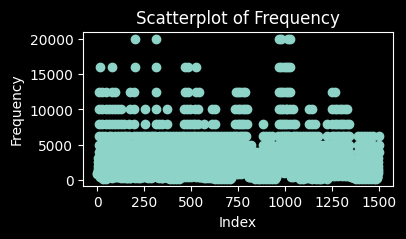

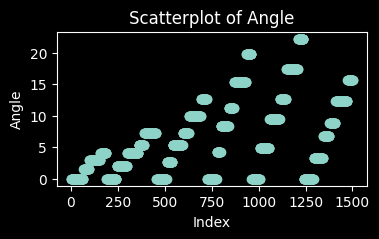

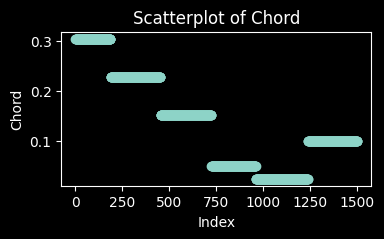

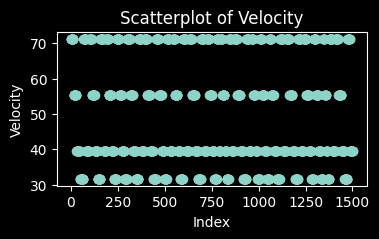

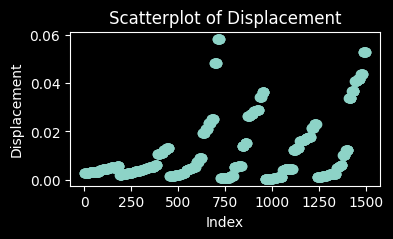

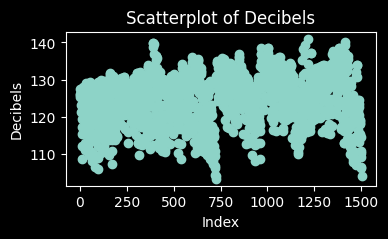

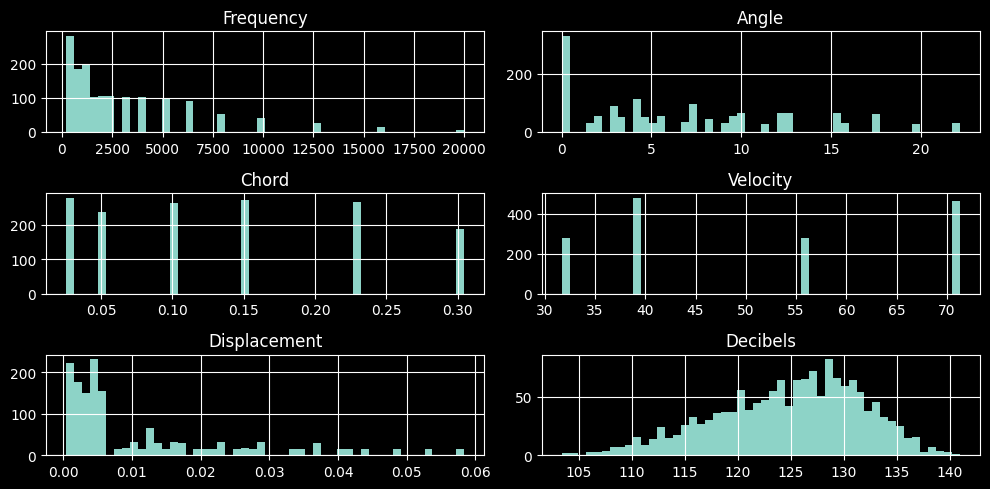

In [12]:
# Data visualization for exploratory analysis
for column in df.columns:
    plt.style.use('dark_background')
    plt.figure(figsize=(4,2)) 
    plt.scatter(df.index, df[column])
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.title("Scatterplot of " + column)
    plt.show()
    
df.hist(bins = 50, figsize = (10,5))
plt.style.use('dark_background')
plt.tight_layout()
plt.show()

# all features are continuous, possibly angle isnt
# want to predict: decibels

In [13]:
df.describe()


,Frequency,Angle,Chord,Velocity,Displacement,Decibels
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Null values and find outliers via z-score

In [15]:
null_values = df.isnull().sum() #autompg.isnull returns an array of booleans
print(null_values) # no null values, no imputation needed

def find_outliers_z_score(df : pd.DataFrame, column : str) -> pd.DataFrame:
    mean = df[column].mean()
    std_deviation = df[column].std()
    z_scores = (df[column] - mean) / std_deviation
    outliers = df[np.abs(z_scores) > 3]
    if len(outliers) > 0:
        return pd.DataFrame(outliers)
    else:
        return "No outliers"

numerical_df = df.select_dtypes(include=[np.number]) 

print("-"*50)
print("Outliers according to Z score") # outliers are points with a z score greater than 3
for colName in numerical_df.columns:
    print("Column name:", colName)
    print(find_outliers_z_score(df, colName))
    print()
print("-"*50)

# No null values
# Seems to have a lot of outliers according to z score but the frequency outliers do not look crazy but some of
# the displacement outliers may be good candidates for trimming

Frequency       0
Angle           0
Chord           0
Velocity        0
Displacement    0
Decibels        0
dtype: int64
--------------------------------------------------
Outliers according to Z score
Column name: Frequency
      Frequency  Angle   Chord  Velocity  Displacement  Decibels
12        12500    0.0  0.3048      71.3      0.002663   112.241
13        16000    0.0  0.3048      71.3      0.002663   108.721
28        12500    0.0  0.3048      55.5      0.002831   111.076
47        12500    0.0  0.3048      39.6      0.003101   109.619
78        12500    1.5  0.3048      71.3      0.003367   109.222
79        16000    1.5  0.3048      71.3      0.003367   106.582
96        12500    1.5  0.3048      39.6      0.003921   106.111
173       12500    4.0  0.3048      71.3      0.004978   107.405
198       12500    0.0  0.2286      71.3      0.002143   117.624
199       16000    0.0  0.2286      71.3      0.002143   114.984
200       20000    0.0  0.2286      71.3      0.002143   114

## Checking covariance, variance, and multicollinearity

In [17]:
# Checking the variance of the numerical columns, if variance = 0, column is not longer in original dataset
def check_variance(df : pd.DataFrame) -> pd.DataFrame:
    # create pd.DataFrame to store the column names and their variance with each other
    variance_df = pd.DataFrame(columns = ["Variance"], index=df.columns)
    variance_df.fillna(0, inplace=True)
    for colName in df.columns:
        variance_df.loc[colName, "Variance"] = df[colName].var()
    return variance_df
        

def check_covariance(df : pd.DataFrame) -> pd.DataFrame:
    # create pd.DataFrame to store the column names and their covariance with each other
    covariance_df = pd.DataFrame(index=df.columns, columns=df.columns)
    # check covariance between all columns and append the covariance in the correct spot
    for col1 in df.columns:
        for col2 in df.columns:
            covariance_df.loc[col1, col2] = df[col1].cov(df[col2])
            # covariance_df.loc[col1, col2]: row label col1, column label col2
    return covariance_df

    
print(check_variance(numerical_df))
print("-" * 70)
print(check_covariance(numerical_df)) # notice that the covariance between a column and itself is the variance of that column


                  Variance
Frequency     9.938717e+06
Angle         3.502424e+01
Chord         8.749868e-03
Velocity      2.425116e+02
Displacement  1.729287e-04
Decibels      4.759146e+01
----------------------------------------------------------------------
                   Frequency       Angle     Chord     Velocity Displacement   
Frequency     9938717.383697 -5089.05844   -1.0795  6562.137785    -9.539578  \
Angle            -5089.05844   35.024241 -0.279488     5.415383     0.058633   
Chord                -1.0795   -0.279488   0.00875     0.005516    -0.000272   
Velocity         6562.137785    5.415383  0.005516   242.511614    -0.000814   
Displacement       -9.539578    0.058633 -0.000272    -0.000814     0.000173   
Decibels        -8497.394774   -6.373423 -0.152396    13.439956    -0.028365   

                 Decibels  
Frequency    -8497.394774  
Angle           -6.373423  
Chord           -0.152396  
Velocity        13.439956  
Displacement    -0.028365  
Decibels   

## Adjusted R-squared function

In [18]:
def adjusted_r2_score(XTest : pd.DataFrame, r2 : float) -> float:
    n = XTest.shape[0]
    p = XTest.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adj_r2

## Set our variables for our models

In [19]:
# put our features into a variable
X = df[["Frequency", "Angle", "Chord", "Velocity", "Displacement"]]

#variable that we want to predict
y = df["Decibels"]



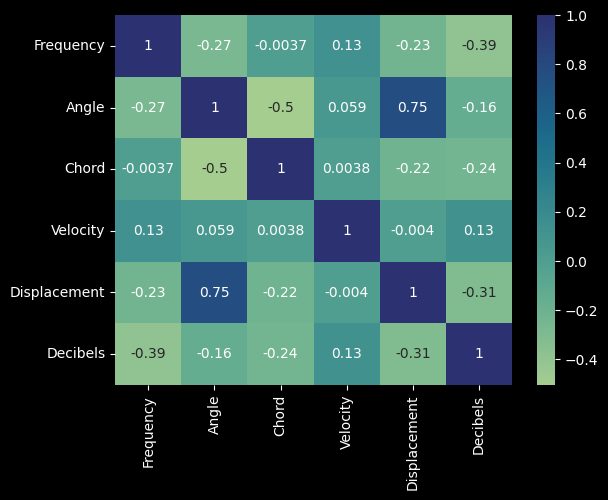

In [20]:
# correlation matrix
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="crest")
plt.show()

In [21]:
# Compute VIF scores for each column
vif = pd.DataFrame()
vif["feature"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Print the VIF scores
print(vif)

# all VIF scores are relatively low

        feature        VIF
0     Frequency   1.990306
1         Angle   7.655110
2         Chord   4.270062
3      Velocity  12.834525
4  Displacement   4.392963
5      Decibels  16.664049


## Transform some data

In [22]:
# have 0 values/ so find min values before transforming
print(min(df["Decibels"]))
print(min(filter(lambda x: x > 0, df["Decibels"])))



103.38
103.38


In [23]:
# new df to transform data in
transform_df = df.copy()

# log transform TPSA
transform_df["log_Decibels"] = np.log10(transform_df["Decibels"])

In [24]:
# create new y value for transformed regression yt = y transformed
yt = transform_df[["log_Decibels"]]
yt

,log_Decibels
0,2.101063
1,2.097608
2,2.100202
3,2.105820
4,2.105377
...,...
1498,2.042434
1499,2.038437
1500,2.027774
1501,2.026223


## In-sample

In [27]:
# create a linear regression model
linearRegressionModel = LinearRegression()
# fit the model to the training data
linearRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = linearRegressionModel.predict(X)
# r2 score
r2 = r2_score(y, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Linear Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a lasso regression model
lassoRegressionModel = Lasso(alpha=0.1)
# fit the model to the training data
lassoRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = lassoRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Lasso Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a ridge regression model
ridgeRegressionModel = Ridge()
# fit the model to the training data
ridgeRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = ridgeRegressionModel.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Ridge Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a symbolic regression model
symbolic_model = SymbolicRegressor(population_size=5000, function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'), metric='rmse')
#Gregg's parameters
#symbolic_model = SymbolicRegressor(population_size=5000, stopping_criteria=0.01, p_crossover=0.7, p_subtree_mutation=0.1, p_hoist_mutation=0.05, p_point_mutation=0.1, max_samples=0.9, parsimony_coefficient=0.01, random_state=42)
# fit our training data into the model
symbolic_model.fit(X,y)
# predict values on test data
y_predictions = symbolic_model.predict(X)
# evaluate the model using R^2
r2 = r2_score(y, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Symbolic Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

# create a transformed linear regression model
transformedRegressionModel = LinearRegression()
# fit the model to the training data
transformedRegressionModel.fit(X, y)
# make predictions on the test data
y_predictions = linearRegressionModel.predict(X)
y_predictions = np.array(10 ** pd.Series(y_predictions))
# r2 score
r2 = r2_score(yt, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X, r2)
# print metrics
print("Transformed Regression")
print("R2:", r2)
print("Adjusted R2:", adj_r2)
print()

Linear Regression
R2: 0.5157097420928731
Adjusted R2: 0.5140922061613196

Lasso Regression
R2: 0.45057075303655514
Adjusted R2: 0.4487356520112932

Ridge Regression
R2: 0.4885692672601716
Adjusted R2: 0.4868610817800786

Symbolic Regression
R2: 0.13656748607108637
Adjusted R2: 0.13368360993905937

Transformed Regression
R2: -1.6028270356952636e+274
Adjusted R2: -1.6081804994083406e+274



## 80-20 Train-test-split

In [29]:
# create train-test variables
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)


# create a linear regression model
linearRegressionModel = LinearRegression()
# fit the model to the training data
linearRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = linearRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
# save summaries into a txt file
with open("./summaries_and_plots/airfoil_sum.txt", "w") as file:
    print("TnT Linear Regression", file=file)
    print("R2:", r2, file=file)
    print("Adjusted R2:", adj_r2, file=file)
    print("\n", file=file)

# create a lasso regression model
lassoRegressionModel = Lasso(alpha=0.1)
# fit the model to the training data
lassoRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = lassoRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
with open("./summaries_and_plots/airfoil_sum.txt", "a") as file:
    print("TnT Lasso Regression", file=file)
    print("R2:", r2, file=file)
    print("Adjusted R2:", adj_r2, file=file)
    print("\n", file=file)

# create a ridge regression model
ridgeRegressionModel = Ridge()
# fit the model to the training data
ridgeRegressionModel.fit(X_train, y_train)
# make predictions on the test data
y_predictions = ridgeRegressionModel.predict(X_test)
# calculate r2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
with open("./summaries_and_plots/airfoil_sum.txt", "a") as file:
    print("TnT Ridge Regression", file=file)
    print("R2:", r2, file=file)
    print("Adjusted R2:", adj_r2, file=file)
    print("\n", file=file)

# create a symbolic regression model
symbolic_model = SymbolicRegressor(population_size=5000, function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'), metric='rmse')
# fit our training data into the model
symbolic_model.fit(X_train, y_train)
# predict values on test data
y_predictions = symbolic_model.predict(X_test)
# evaluate the model using R^2
r2 = r2_score(y_test, y_predictions)
# calculate adjusted r2
adj_r2 = adjusted_r2_score(X_train, r2)
# save metrics to a txt file
with open("./summaries_and_plots/airfoil_sum.txt", "a") as file:
    print("TnT Symbolic Regression", file=file)
    print("R2:", r2, file=file)
    print("Adjusted R2:", adj_r2, file=file)
    print("\n", file=file)

# # scale data to use with perceptron
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# # create a perceptron model
# perceptron_model = Perceptron()
# # fit our training data into the model
# perceptron_model.fit(X_train,y_train)

# # predict values on test data
# y_predictions = perceptron_model.predict(X_test)
# # evaluate the model using R^2
# r2 = r2_score(y_test, y_predictions)
# # calculate adjusted r2
# adj_r2 = adjusted_r2_score(X_train, r2)
# # print metrics
# print("Perceptron Regression")
# print("R2:", r2)
# print("Adjusted R2:", adj_r2)

## 5x Cross-validation

In [33]:

kf = KFold(n_splits=5, random_state = 42, shuffle = True) # 5 fold cross validation: KFold(n_splits=5, random_state=None, shuffle=False)
# n_splits = 5: number of splits is 5, so 20% of data is going to be used for the training and testing partitions (20% test, 20% + 20% + 20% + 20% train) )
# random_state = True: sets a random seet to ensure results are reproducible
# shuffle = True: Shuffles the data prior to creating the KFold partitions 

# create lists to hold performance metrics
# Create DataFrames for predicted and actual variables for statistical summaries of actual vs estimated
linear_R2 = []
linear_adj_R2 = []
linear_regression_predicted = pd.DataFrame(columns = ["Predicted"], dtype = "int64")

lasso_R2 = []
lasso_regression_adj_R2 = []
lasso_regression_predicted = pd.DataFrame(columns = ["Predicted"], dtype = "int64")

ridge_R2 = []
ridge_regression_adj_R2 = []
ridge_regression_predicted = pd.DataFrame(columns = ["Predicted"], dtype = "int64")

symbolic_R2 = []
symbolic_regression_adj_R2 = []
symbolic_regression_predicted = pd.DataFrame(columns = ["Predicted"], dtype = "int64")

actualdf = y

for train_index, test_index in kf.split(X): # training and testing indices are newly generated per iteration
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] #pd.DataFrame.iloc[indices] is used to grab specific index values
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] #pd.DataFrame.iloc[indices] is used to grab specific index values
        
    # create a linear regression model
    linearRegressionModel = LinearRegression()
    # fit the model to the training data
    linearRegressionModel.fit(X_train, y_train)
    # make predictions on the test data
    y_predictions = linearRegressionModel.predict(X_test)
    # calculate r2 and adjusted r2
    r2 = r2_score(y_test, y_predictions)
    adj_r2 = adjusted_r2_score(X_train, r2)
    # append r2 and adjusted r2 to correct model list
    linear_R2.append(r2)
    linear_adj_R2.append(adj_r2)
    
    # Add predicted values to linear_regression_predicted DataFrame
    # linear_regression_predicted = linear_regression_predicted.append(pd.DataFrame({"Predicted": y_predictions}))
    # Add predicted values to linear_regression_predicted DataFrame
    linear_regression_predicted = pd.concat([linear_regression_predicted, pd.DataFrame({"Predicted": y_predictions})], ignore_index=True)
    # print(linear_regression_predicted)
    
    # create a lasso regression model
    lassoRegressionModel = Lasso(alpha=0.1)
    # fit the model to the training data
    lassoRegressionModel.fit(X_train, y_train)
    # make predictions on the test data
    y_predictions = lassoRegressionModel.predict(X_test)
    # calculate r2 and adjusted r2
    r2 = r2_score(y_test, y_predictions)
    adj_r2 = adjusted_r2_score(X_train, r2)
    # append r2 and adjusted r2 to correct model list
    lasso_R2.append(r2)
    lasso_regression_adj_R2.append(adj_r2)
    # Add predicted values to linear_regression_predicted DataFrame
    # lasso_regression_predicted = lasso_regression_predicted.append(pd.DataFrame({"Predicted": y_predictions}))
    lasso_regression_predicted = pd.concat([lasso_regression_predicted, pd.DataFrame({"Predicted": y_predictions})], ignore_index=True)
    
    # create a ridge regression model
    ridgeRegressionModel = Ridge()
    # fit the model to the training data
    ridgeRegressionModel.fit(X_train, y_train)
    # make predictions on the test data
    y_predictions = ridgeRegressionModel.predict(X_test)
    # calculate r2 and adjusted r2
    r2 = r2_score(y_test, y_predictions)
    adj_r2 = adjusted_r2_score(X_train, r2)
    # append r2 and adjusted r2 to correct model list
    ridge_R2.append(r2)
    ridge_regression_adj_R2.append(adj_r2)
    # Add predicted values to linear_regression_predicted DataFrame
    # ridge_regression_predicted = ridge_regression_predicted.append(pd.DataFrame({"Predicted": y_predictions}))
    ridge_regression_predicted = pd.concat([ridge_regression_predicted, pd.DataFrame({"Predicted": y_predictions})], ignore_index=True)

    # create a symbolic regression model
    symbolic_model = SymbolicRegressor(population_size=5000, function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 'max', 'min'), metric='rmse')
    # fit our training data into the model
    symbolic_model.fit(X_train, y_train)
    # predict values on test data
    y_predictions = symbolic_model.predict(X_test)
    # evaluate the model using R^2
    r2 = r2_score(y_test, y_predictions)
    # calculate adjusted r2
    adj_r2 = adjusted_r2_score(X_train, r2)
    # append r2 and adjusted r2 to correct model list
    symbolic_R2.append(r2)
    symbolic_regression_adj_R2.append(adj_r2)
    # Add predicted values to linear_regression_predicted DataFrame
    # symbolic_regression_predicted = ridge_regression_predicted.append(pd.DataFrame({"Predicted": y_predictions}))
    symbolic_regression_predicted = pd.concat([symbolic_regression_predicted, pd.DataFrame({"Predicted": y_predictions})], ignore_index=True)

with open("./summaries_and_plots/airfoil_sum.txt", "a") as file:
    print("\n", file=file)
    print("5x CV Average Performance Linear Regression", file=file)
    print("R^2:", sum(linear_R2)/len(linear_R2), file=file)
    print("Adjusted R^2:", sum(linear_adj_R2)/len(linear_adj_R2), file=file)
    print("\n", file=file)
    print("Linear Regression Statistical Summaries (Actual vs Predicted)", file=file)
    print(linear_regression_predicted.describe(), file=file)
    print("Actual", file=file)
    print(actualdf.describe(), file=file)
    print("-" * 70, file=file)
    print("\n", file=file)
    
    print("5x CV Average Performance Lasso Regression", file=file)
    print("R^2:", sum(lasso_R2)/len(lasso_R2), file=file)
    print("Adjusted R^2:", sum(lasso_regression_adj_R2)/len(lasso_regression_adj_R2), file=file)
    print("\n", file=file)
    print("Lasso Regression Statistical Summaries (Actual vs Predicted)", file=file)
    print(lasso_regression_predicted.describe(), file=file)
    print("Actual", file=file)
    print(actualdf.describe(), file=file)
    print("-" * 70, file=file)
    print("\n", file=file)

    print("5x CV Average Performance Ridge Regression", file=file)
    print("R^2:", sum(ridge_R2)/len(ridge_R2), file=file)
    print("Adjusted R^2:", sum(ridge_regression_adj_R2)/len(ridge_regression_adj_R2), file=file)
    print("\n", file=file)
    print("Ridge Regression Statistical Summaries (Actual vs Predicted)", file=file)
    print(ridge_regression_predicted.describe(), file=file)
    print("Actual", file=file)
    print(actualdf.describe(), file=file)
    print("-" * 70, file=file)
    print("\n", file=file)

    print("5x CV Average Performance Symbolic Regression", file=file)
    print("R^2:", sum(symbolic_R2)/len(symbolic_R2), file=file)
    print("Adjusted R^2:", sum(symbolic_regression_adj_R2)/len(symbolic_regression_adj_R2), file=file)
    print("\n", file=file)
    print("Ridge Regression Statistical Summaries (Actual vs Predicted)", file=file)
    print(ridge_regression_predicted.describe(), file=file)
    print("Actual", file=file)
    print(actualdf.describe(), file=file)


## Plots

In [35]:
# Plot of the best model

columns = X.columns
columnCombos = []

for i in range(2, len(columns)+1):
    columnCombos.extend(list(itertools.combinations(columns, i)))
    # itertools.combination(iterable, length of iterable) generates all unqiue combiation of an iterable at length
    # list() casts the iterools object into a list so we can extend columnCombos
    # list.extend adds multiple elements to the end of a list
    
linearRegressionR2 = {}
linearRegressionadjustedR2 = {}
linearRegressionCVR2 = {}
for combination in columnCombos:
    combination = list(combination) # cast combination from tuple to list
    xdf = pd.DataFrame() # create a blank DataFrame
    # xdf = xdf.append(df[combination])
    xdf = pd.concat(xdf,pd.DataFrame(df[combination])) # append the unique combination of columns to the blank DataFrame
    X = xdf
    y = df["Decibels"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    linearRegressionModel = LinearRegression() # create a linear regression model
    linearRegressionModel.fit(X_train, y_train) # fit the model to the training data
    y_predictions = linearRegressionModel.predict(X_test) # make predictions on the test data
    r2 = r2_score(y_test, y_predictions) # calculate r2
    adj_r2 = adjusted_r2_score(X_train, r2) # calculate adjusted r2
    cv_r2_scores = cross_val_score(linearRegressionModel, X_train, y_train, cv=5, scoring='r2')
    cv_r2 = np.mean(cv_r2_scores)
    # append column combination and calculated metrics to respective dictionaries 
    linearRegressionR2[str(combination)] = r2
    linearRegressionadjustedR2[str(combination)] = adj_r2
    linearRegressionCVR2[str(combination)] = cv_r2
    mse = mean_squared_error(y_test, y_predictions)
    sse = mse * len(y_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_predictions)


with open("./summaries_and_plots/airfoil_sum.txt", "a") as file:
    print("\n", file=file)
    print("---------- Best performances below ----------", file=file)
    print("-" * 45, file=file)
    print("Column combination", file=file)
    print([key for key, value in linearRegressionR2.items() if value == max(linearRegressionR2.values())][0], file=file)
    print("R2:", max(linearRegressionR2.values()), file=file)
    print("-" * 45, file=file)
    print("Column combination", file=file)
    print([key for key, value in linearRegressionadjustedR2.items() if value == max(linearRegressionadjustedR2.values())][0], file=file)
    print("Adjusted R2:", max(linearRegressionadjustedR2.values()), file=file)
    print("-" * 45, file=file)
    print("Column combination", file=file)
    print([key for key, value in linearRegressionCVR2.items() if value == max(linearRegressionCVR2.values())][0], file=file)
    print("CV R2:", max(linearRegressionCVR2.values()), file=file)
    print("-" * 45, file=file)
    print("Mean Squared Error", file=file)
    print(mse, file=file)
    print("-" * 45, file=file)
    print("Sum of Squared Error", file=file)
    print(sse, file=file)
    print("-" * 45, file=file)
    print("Root Mean Squared Error", file=file)
    print(rmse, file=file)
    print("-" * 45, file=file)
    print("Mean Absolute Error", file=file)
    print(mse, file=file)
    print("-" * 45, file=file)


# create a visualization tracking all R2 and adjusted R2 generated
num_params = [len(eval(key)) for key in linearRegressionR2.keys()] # get the number of parameters for each column combination
r2_values = list(linearRegressionR2.values()) # cast all R2 values of linearRegressionR2 dictionary into a list
adj_r2_values = list(linearRegressionadjustedR2.values()) # cast all R2 values of linearRegressionadjustedR2 dictionary into a list
cv_r2_values = list(linearRegressionCVR2.values()) # cast all CV R2 values of linearRegressionCVR2 dictionary into a list

plt.scatter(num_params, r2_values, label = "R^2") # plot the number of parameters against R2
plt.scatter(num_params, adj_r2_values, label = "Adjusted R^2") # plot the number of parameters against adjusted R2
plt.scatter(num_params, cv_r2_values, label = "CV R^2") # plot the number of parameters against CV R2

# add a legend and labels to the scatterplot and show
plt.legend()
plt.xlabel("Number of Parameters")
plt.ylabel("R^2 / Adjusted R^2 / CV R^2")
plt.show()

# create a visualization averaging all R2 and adjusted R2 generated for their respective paramters used
for element in num_params:
    sumList = []
    for i in range(len(linearRegressionR2)):
        if len(eval(list(linearRegressionR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionR2.values())[i]))
    plt.scatter(element, sum(sumList)/len(sumList), label = "R^2", c = "red")

for element in num_params:
    sumList = []
    for i in range(len(linearRegressionadjustedR2)):
        if len(eval(list(linearRegressionadjustedR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionadjustedR2.values())[i]))
    plt.scatter(element, sum(sumList)/len(sumList), label = "Adjusted R^2", c = "blue")

for element in num_params:
    sumList = []
    for i in range(len(linearRegressionCVR2)):
        if len(eval(list(linearRegressionCVR2.keys())[i])) == element:
            sumList.append(float(list(linearRegressionCVR2.values())[i]))
    plt.scatter(element, sum(sumList)/len(sumList), label = "CV R^2", c = "green")

plt.title("R^2 (Red) vs Adjusted R^2 (Blue) vs CV R^2 (Green)")
plt.xlabel("Number of Parameters")
plt.ylabel("R^2 / Adjusted R^2 / CV R^2")
plt.savefig("./summaries_and_plots/airfoil_r^2_plot.png")
plt.show()

x1 = np.linspace(100, 140, 100)
y1 = x1
plt.scatter(y_predictions, y_test)
plt.plot(x1, y1, color = "red")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs Predicted Values")
plt.savefig("./summaries_and_plots/airfoil_actualvspredicted_plot.png")

plt.show()


TypeError: concat() takes 1 positional argument but 2 were given